## Final Project: DS-SEA-4
**Jenna White  **
  
**Question:**  
Can I use past behavior on the Rover.com site to identify people who should be prioritized for diversion investigations?  
  
**Data:**  
3200 observations of conversations triggered for manual inspection by our diversion team based on message composition. I will be seeing if I can create a model that will predict if the sitter will be a Diverter based on the participant data, so that we can better prioritize these conversations when they hit our queue (there are currently a lot of false positives).

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = '/Users/jennawhite/Documents/wild_west/Rover_Diversion/data_diversion_11292.csv'
data = pd.read_csv(url)

In [4]:
data.shape

(3200, 56)

### Data Pre-Processing

In [7]:
data.years_of_experience.mean() #13.125
data.years_of_experience.fillna(13.0, inplace=True)

In [8]:
#not everyone has notes from our customer-facing teams, I've replaced N/As with 'none' so that I can do text processing
data.staff_notes.fillna('none',inplace=True)
data.owner_staff_notes.fillna('none',inplace=True)

In [9]:
data.voice_calls.fillna(0, inplace=True)
data.calls_duration.fillna(0, inplace=True)

In [10]:
# create a feature 'mg_code' that indicates if no meet&greet was planned - 0 -,
# one was planned and didnt happen -1- or did happen -2-
data['happened'].fillna(3, inplace='True')
data['mg_code'] = data.happened.map({3.0:0,0.0:1,1.0:2})

In [11]:
# there is a huge weight towards female sitters - so what I have done is create a feature called 'is_female'
# I map gender 'unknowns' and 'male' to 0
data.gender.fillna('u', inplace=True)
data['is_female'] = data.gender.map({'u':0,'m':0,'f':1})

In [12]:
#categorizes service as overnight or not...
data['overnight']=data.service_type.map({'dog-walking':0,'doggy-day-care':0,'drop-in':0,'overnight-boarding':1,'overnight-traveling':1})

In [13]:
#...plus has the exact service as a get_dummies
data = pd.concat([data,pd.get_dummies(data['service_type'],prefix='svc')],axis=1)

In [14]:
#resulting data set
data.head()

,conversation_id,diversion_tickets,first_diversion_ticket,last_diversion_ticket,trigger_content_type_id,is_diverting,id,requester_id,provider_id,convo_added,...,voice_calls,calls_duration,mg_code,is_female,overnight,svc_dog-walking,svc_doggy-day-care,svc_drop-in,svc_overnight-boarding,svc_overnight-traveling
0,3370262,1,11/17/16,11/17/16,36,0,3370262,1398797,1805568,10/28/16,...,1.0,12.0,2,1,1,0.0,0.0,0.0,0.0,1.0
1,3286711,1,11/7/16,11/7/16,36,1,3286711,410655,1976198,10/17/16,...,0.0,0.0,2,1,1,0.0,0.0,0.0,1.0,0.0
2,3370262,1,11/17/16,11/17/16,36,0,3370262,1398797,1805568,10/28/16,...,1.0,12.0,2,1,1,0.0,0.0,0.0,0.0,1.0
3,3359776,1,11/10/16,11/10/16,215,0,3359776,1204294,1635327,10/26/16,...,0.0,0.0,2,0,1,0.0,0.0,0.0,1.0,0.0
4,3510412,1,11/25/16,11/25/16,36,0,3510412,1735769,247,11/16/16,...,0.0,0.0,2,1,1,0.0,0.0,0.0,0.0,1.0


In [15]:
data.columns

Index([u'conversation_id', u'diversion_tickets', u'first_diversion_ticket',
       u'last_diversion_ticket', u'trigger_content_type_id', u'is_diverting',
       u'id', u'requester_id', u'provider_id', u'convo_added', u'start_date',
       u'days_til_start', u'service_type', u'provider_first_response_minutes',
       u'has_stay', u'is_repeat_customer', u'source', u'provider_group_id',
       u'need_id', u'requester_was_new_customer', u'years_of_experience',
       u'posted_on_craigslist', u'match_date', u'approved_on',
       u'sitter_user_id', u'sitter_account_added', u'dog_history', u'active',
       u'gender', u'birth_year', u'email_verified', u'ratings_average',
       u'ratings_count', u'testimonial_count', u'profile_quality',
       u'response_percent', u'response_time', u'marketing_partner',
       u'stay_images_global_opt_out', u'staff_notes', u'does_not_have_dogs',
       u'owner_user_id', u'owner_account_added', u'owner_active',
       u'owner_gender', u'owner_birth_year', u'o

## Feature Selection
### Profile Data

In my Data Exploration notebook, I went through many of the columns above to see if there was any correlation between the response variable (is_diverting) and the selected feature. Here are a few that showed some promise:

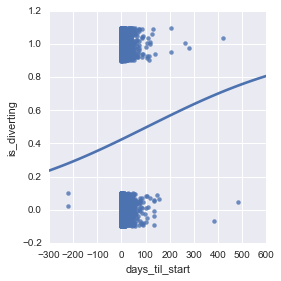

In [18]:
sns.lmplot(x='days_til_start', y='is_diverting', data=data, size=4, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

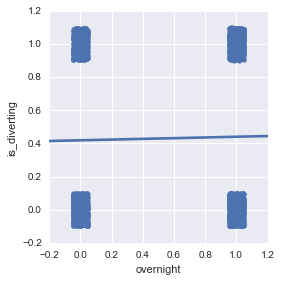

In [19]:
#by overnight or day-time, there doesn't seem to be a bias towards diverting...
sns.lmplot(x='overnight', y='is_diverting', data=data, size=4, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

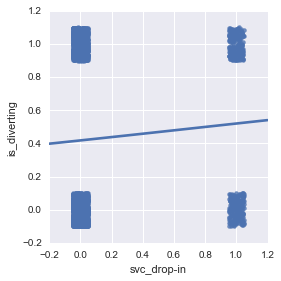

In [20]:
# ...BUT drop-in had a much stronger correlation than other services
sns.lmplot(x='svc_drop-in', y='is_diverting', data=data, size=4, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

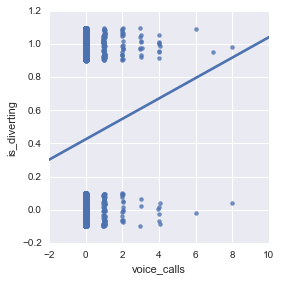

In [21]:
sns.lmplot(x='voice_calls', y='is_diverting', data=data, size=4, ci=None, x_jitter=0.05, y_jitter=0.1)

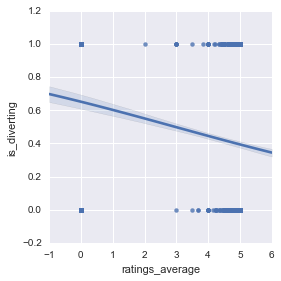

In [22]:
sns.lmplot(x='ratings_average', y='is_diverting', data=data, size=4, logistic=True)

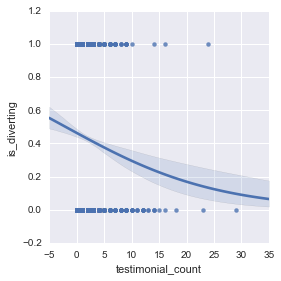

In [23]:
sns.lmplot(x='testimonial_count', y='is_diverting', data=data, size=4, logistic=True)

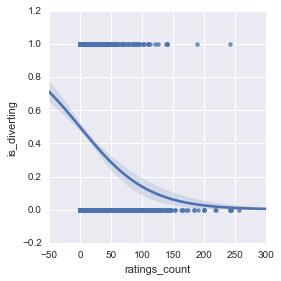

In [24]:
sns.lmplot(x='ratings_count', y='is_diverting', data=data, size=4, logistic=True)

Using the outputs from these, and other, exploratory charts, I created a test feature set for behavioral and profile data:

In [25]:
test_columns = [
                'days_til_start',
                'years_of_experience',
                'ratings_average',
                'ratings_count',
                'testimonial_count',
                'calls_duration',
                'voice_calls',
               'svc_drop-in',
               ]


## Staff_Notes


Another important column in this dataset is "staff_notes" -- this refers to unstructured notes written by our customer-facing teams. They can be negative, positive, or just an internal note. To parse these, I used TD-IDF.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

In [29]:
print 'No Owner Staff Notes for', len(data[data['owner_staff_notes']=='none']),'conversations (97.6%).'
print 'No Sitter Staff Notes for', len(data[data['staff_notes']=='none']),'conversations (78.5%).'
print len(data)


No Owner Staff Notes for 3122 conversations (97.6%).
No Sitter Staff Notes for 2513 conversations (78.5%).
3200


Because of the above, I decided to just parse Sitter staff notes and look to see if there were any text features that were found consistently in notes for people who have been flagged as diverting.

In [32]:
text_columns = ['staff_notes','is_diverting']
datav = data[text_columns]
datav1 = datav[datav['is_diverting']==1]

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction import text


notes = datav1.staff_notes

vectorizer2 = TfidfVectorizer(stop_words='english', max_features=250, decode_error='ignore', ngram_range=(1, 2))

In [34]:
X = vectorizer2.fit_transform(notes)
indices = np.argsort(vectorizer2.idf_)[:-1:]
features = vectorizer2.get_feature_names()
top_n = 15
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'sitter', u'16', u'dog', u'2016', u'11', u'10', u'owner', u'stay', u'dogs', u'rover', u'qa', u'rg', u'home', u'rover dog', u'coached']


**Above are the features that are the most common in staff_notes of sitters who have been confirmed diverters.**  

**I then wanted to see if there were any clear outliers in notes of diverters vs the most common words in the notes of non-diverters**

In [35]:
datav0 = data[data['is_diverting']==0]

notes0 = datav0.staff_notes
vectorizer2 = TfidfVectorizer(stop_words='english', max_features=5000, decode_error='ignore', ngram_range=(1, 2))

In [36]:
X2 = vectorizer2.fit_transform(notes0)
indices2 = np.argsort(vectorizer2.idf_)[:-1:]
features2 = vectorizer2.get_feature_names()
top_n = 15
top_features2 = [features2[i] for i in indices2[:top_n]]
print top_features2

[u'sitter', u'16', u'dog', u'2016', u'owner', u'rover', u'stay', u'10', u'11', u'rover dog', u'dogs', u'rd', u'vet', u'coached', u'care']


In [37]:
top_features # for diverters


[u'sitter',
 u'16',
 u'dog',
 u'2016',
 u'11',
 u'10',
 u'owner',
 u'stay',
 u'dogs',
 u'rover',
 u'qa',
 u'rg',
 u'home',
 u'rover dog',
 u'coached']

In [38]:
top_features2 #non-diverters

[u'sitter',
 u'16',
 u'dog',
 u'2016',
 u'owner',
 u'rover',
 u'stay',
 u'10',
 u'11',
 u'rover dog',
 u'dogs',
 u'rd',
 u'vet',
 u'coached',
 u'care']

Actually the top appearing list for diverters and non-diverters are very similar - rg and qa are a bit higher up in the diverter list, but if you expand the feature cut-off, they appear pretty soon in the list. So instead of pulling out only a few features, I'm going to use the whole dictionary of 5000 features and evaluate it using a random forest


## Tuning the Model
### Profile Stats

In [68]:
#Null Accuracy: 43.16%
print len(data[data['is_diverting']==1])
print len(data)

1381
3200


**As a reminder, here are my starting test columns:**  
test_columns = [  
                *'days_til_start',  
                'years_of_experience',  
                'ratings_average',  
                'ratings_count',  
                'testimonial_count',  
                'calls_duration',  
                'voice_calls',  
               'svc_drop-in',*  
               ]



In [44]:
Xdt = data[test_columns]
ydt = data.is_diverting


from sklearn.tree import DecisionTreeClassifier
max_depth_range = range(1, 10)
scores = []

#tune the model to find the optimal max_depth 
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores = cross_val_score(treeclf, Xdt, ydt, cv=10, scoring='accuracy')
    scores.append(np.mean(accuracy_scores))

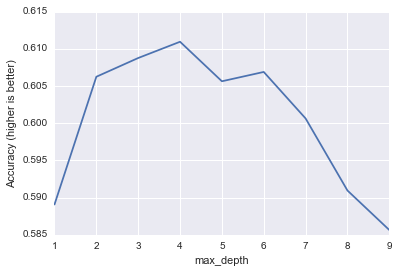

In [45]:
plt.plot(max_depth_range, scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy (higher is better)')

In [46]:
sorted(zip(scores, max_depth_range))


[(0.58563976454848199, 9),
 (0.58907138680553517, 1),
 (0.59094740915438615, 8),
 (0.60063296211388795, 7),
 (0.60563002324241455, 5),
 (0.60623652025410402, 2),
 (0.60688298042461353, 6),
 (0.60875598455551327, 3),
 (0.61094059451264171, 4)]

In [47]:
# max_depth=4 had the best accuracy score at 61.09
treeclf = DecisionTreeClassifier(max_depth = 4, random_state=1)
treeclf.fit(Xdt, ydt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [48]:
pd.DataFrame({'feature':test_columns, 'importance':treeclf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
3,ratings_count,0.578360
2,ratings_average,0.192940
4,testimonial_count,0.071291
0,days_til_start,0.052182
5,calls_duration,0.048678
1,years_of_experience,0.032510
7,svc_drop-in,0.024038
6,voice_calls,0.000000


In [49]:
from sklearn.cross_validation import cross_val_score
score = np.mean(cross_val_score(treeclf, Xdt, ydt, cv=10, scoring='accuracy'))
print score

0.610940594513


** ---> The data I will be using in the model is 'ratings_count', 'ratings_average', 'testimonial_count' and 'days_til_start'**

### Tuning the Tfidf Vectorizer features

In [57]:
X = data.staff_notes
y = data.is_diverting


from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,random_state=1)


vect_x = TfidfVectorizer(stop_words='english', max_features=4000, decode_error='ignore', ngram_range=(1, 2))

In [58]:
xtrain_dtm=vect_x.fit_transform(xtrain)
xtest_dtm = vect_x.transform(xtest)
print xtrain_dtm.shape
print xtest_dtm.shape

(2400, 4000)
(800, 4000)


In [59]:
step = np.arange(0.5,5,0.5)
for c in step:
    log_reg = LogisticRegression(C=c).fit(xtrain_dtm, ytrain)
    print "C= ", c, "  Accuracy: ", round(100 * log_reg.score(xtest_dtm, ytest),2)

# C=2.0 is the most tuned
    

C=  0.5   Accuracy:  56.0
C=  1.0   Accuracy:  56.0
C=  1.5   Accuracy:  56.13
C=  2.0   Accuracy:  56.38
C=  2.5   Accuracy:  56.25
C=  3.0   Accuracy:  56.13
C=  3.5   Accuracy:  56.25
C=  4.0   Accuracy:  56.25
C=  4.5   Accuracy:  56.0


In [60]:
log_regx = LogisticRegression(C=2.0)
log_regx.fit(xtrain_dtm, ytrain)
y_pred_class = log_regx.predict(xtest_dtm)
print metrics.accuracy_score(ytest,y_pred_class)

0.56375


### Random Forest OOB Score

In [61]:
feature_columns = [
'days_til_start',
'years_of_experience',
'ratings_average',
'ratings_count',
'testimonial_count',
]

In [62]:
from sklearn.ensemble import RandomForestClassifier
rcl = RandomForestClassifier()
rcl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
Xrf = data[feature_columns]
yrf = data.is_diverting

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

rfscores = []

for estimator in estimator_range:
    rcl = RandomForestClassifier(n_estimators=estimator, random_state=1)
    acc_scores = cross_val_score(rcl, Xrf, yrf, cv=5, scoring='accuracy')
    rfscores.append(np.mean(acc_scores))

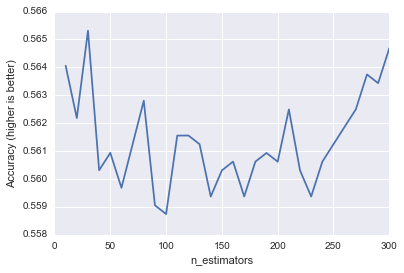

In [69]:
plt.plot(estimator_range, rfscores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (higher is better)')

In [70]:
sorted(zip(rfscores,estimator_range))

[(0.55874272459161278, 100),
 (0.55905522459161272, 90),
 (0.5593696838249117, 140),
 (0.55937016829264719, 230),
 (0.55937066191567841, 170),
 (0.55968218077314646, 60),
 (0.56030571974052668, 220),
 (0.56030767134441251, 150),
 (0.56031255111706812, 40),
 (0.56061870420826232, 240),
 (0.56061919630541091, 200),
 (0.56062114943517938, 180),
 (0.56062115096106191, 160),
 (0.5609321868766769, 190),
 (0.56093560103906503, 50),
 (0.56124272611749537, 70),
 (0.5612456588639132, 250),
 (0.56124566344156113, 130),
 (0.56155327909125752, 110),
 (0.56155717924726378, 120),
 (0.5618706558121479, 260),
 (0.56218169783129357, 20),
 (0.56249224622740779, 210),
 (0.56249370573414481, 270),
 (0.56280425565614167, 80),
 (0.56343315886391321, 290),
 (0.56374517134441249, 280),
 (0.56405815886391319, 10),
 (0.56468267287029517, 300),
 (0.56531450882448442, 30)]

In [87]:
#30 estimators had the highest accuracy

feature_range = range(1, len(feature_columns)+1)
rf2_scores = []

for feature in feature_range:
    rcl = RandomForestClassifier(n_estimators=30, max_features=feature, random_state=1)
    acc_scores = cross_val_score(rcl, Xrf, yrf, cv=10, scoring='accuracy')
    rf2_scores.append(np.mean(acc_scores))

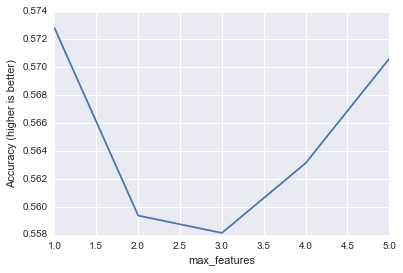

In [93]:
plt.plot(feature_range, rf2_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy (higher is better)')

In [94]:
sorted(zip(rf2_scores,feature_range))

[(0.55812997441381262, 3),
 (0.55937409667086579, 2),
 (0.56313190314358541, 4),
 (0.57062511901971691, 5),
 (0.57282333994960877, 1)]

In [95]:
rcl = RandomForestClassifier(n_estimators=10, max_features=1, oob_score=True, random_state=1)
rcl.fit(Xrf, yrf)

/Users/jennawhite/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [97]:
pd.DataFrame({'feature':feature_columns, 'importance':rcl.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,days_til_start,0.289299
1,years_of_experience,0.247142
3,ratings_count,0.236478
4,testimonial_count,0.125273
2,ratings_average,0.101808


In [98]:
rcl.oob_score_

0.57656249999999998

The Random Forest shows that years of experience and days til start may have more predictive usefulness for OOB samples, than the decision tree showed

### Combining TDIDF features with DT features

In [88]:
data_combined = pd.concat([data[feature_columns],data.is_diverting],axis=1)

In [89]:
tfidfvect = TfidfVectorizer(stop_words='english', max_features=4000, decode_error='ignore', ngram_range=(1, 2))
notesdata= data.staff_notes

In [90]:
textdata = tfidfvect.fit_transform(notesdata)
t=textdata.toarray()

In [91]:
data_combined['tfidf_results'] = list(t)

In [92]:
data_combined.head()

,days_til_start,years_of_experience,ratings_average,ratings_count,testimonial_count,is_diverting,tfidf_results
0,133,25.0,5.00,1,6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,15,15.0,4.83,6,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,133,25.0,5.00,1,6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,13,15.0,5.00,8,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,30.0,5.00,2,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [102]:
features = ['days_til_start',
'years_of_experience',
'ratings_average',
'ratings_count',
'testimonial_count',
]


X = data[features]
y = data.is_diverting


from sklearn.cross_validation import train_test_split
xtrainc, xtestc, ytrainc, ytestc = train_test_split(X,y,random_state=1)

In [105]:
step = np.arange(0.5,5,0.5)
for c in step:
    log_reg = LogisticRegression(C=c).fit(xtrainc, ytrainc)
    print "C= ", c, "  Accuracy: ", round(100 * log_reg.score(xtestc, ytestc),2)

# C=1.0 is the most tuned

C=  0.5   Accuracy:  60.12
C=  1.0   Accuracy:  60.12
C=  1.5   Accuracy:  60.0
C=  2.0   Accuracy:  60.0
C=  2.5   Accuracy:  60.0
C=  3.0   Accuracy:  60.0
C=  3.5   Accuracy:  60.0
C=  4.0   Accuracy:  60.0
C=  4.5   Accuracy:  60.0


In [106]:
log_regc = LogisticRegression(C=1.0)
log_regc.fit(xtrainc, ytrainc)
y_pred_classc = log_regc.predict(xtestc)
print metrics.accuracy_score(ytestc,y_pred_classc)

0.60125


It looks like, at this point, using just the non-text features provides the best predictive outcome

## Conclusions

After exploring many different data fields we keep, relating to performance on the site and content in a sitter's profile, it looks like the following are the most predictive of whether or not a person is actually trying to close a booking off of our profile once they have been flagged by our system:  
- days_til_start
- years_of_experience
- ratings_average
- ratings_count
- testimonial_count  

I will be using new data from our fraud team to test this model against out of sample records. I hope that we will be able to use this model to help prioritize the queue of our fraud team - currently our fraud triggers are quite conservative, and result in a lot of false positives. 

## Future Work  
There are two main items that I'd like to continue working on:  
  
1) Testing a few other models (potentially KNN) as well as trying to use an ensembling strategy like VotingClassifier from sklearn.  
2) Try using Text Blob to do Sentiment Analysis on the staff notes, instead of using TfidfVectorizer.  